In [1]:
from brian2.only import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Structure

# How many levels?
N_levels = 80

# How many neurons in each level (input, output, inhibitory)?
N_Ein = 10
N_Eout = 10
N_I = 5

# How many "sensory" neurons (input, output side)?
N_Sin = 5
N_Sout = 20

# Connection probability
epsilon = 0.5

# Conduction delays
delay_within = 2*msecond
delay_across = 10*msecond

In [3]:
# Neuron model

gl = 10.0*nsiemens   # Leak conductance
el = -60*mV          # Resting potential
E_gaba = -80*mV      # Inhibitory reversal potential (excitatory is 0 mV, implicit.)
vt = -50.*mV         # Spiking threshold
memc = 200.0*pfarad  # Membrane capacitance

tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
tau_gaba = 10.0*ms  # GABAergic synaptic time constant

gbar_ampa = 5*nS
gbar_gaba = 25*nS

eqs_neurons='''
dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-E_gaba)))/memc : volt (unless refractory)
dg_ampa/dt = -g_ampa/tau_ampa : siemens
dg_gaba/dt = -g_gaba/tau_gaba : siemens
'''

In [4]:
# Plasticity model

tau_pre = tau_post = 20*ms
wmax = 1
w0 = .8  # Initial weight for feedforward and lateral (feedback: 0)
dApre = .01
dApost = -dApre * tau_pre / tau_post * 1.05
dApost *= wmax
dApre *= wmax

stdp_eqn = '''
    w : 1
    dApre/dt = -Apre / tau_pre : 1 (event-driven)
    dApost/dt = -Apost / tau_post : 1 (event-driven)'''
stdp_onpre = '''
    g_ampa += w*gbar_ampa
    Apre += dApre
    w = clip(w + Apost, 0, wmax)'''
stdp_onpost = '''
    Apost += dApost
    w = clip(w + Apre, 0, wmax)'''

In [5]:
rng = np.random.default_rng(1)

In [6]:
N_neurons_total = N_levels * (N_Ein+N_Eout+N_I) + N_Sin + N_Sout
neurons = NeuronGroup(N_neurons_total, model=eqs_neurons, threshold='v > vt',
                      reset='v=el', refractory=5*ms, method='euler')
neurons.v = el

def get_subpopulations(population, sizes):
    n = 0
    subpopulations = []
    for s in sizes:
        subpopulations.append(population[n:n+s])
        n += s
    return subpopulations
        
Sin, Sout, Ein, I, Eout = get_subpopulations(neurons, (N_Sin, N_Sout, N_levels*N_Ein, N_levels*N_I, N_levels*N_Eout))

In [7]:
def get_ij(pre, post, p):
    ii, jj = rng.choice(2, (pre.N, post.N), p=[1-p, p]).nonzero()
    return pre.indices[ii], post.indices[jj]

def append2(list1, list2, morefor1, morefor2):
    list1.append(morefor1)
    list2.append(morefor2)

In [8]:
# Collect all similar synapses into a single object
# The reasoning is the following:
# Each Synapse object has an overhead; we want to reduce this within reason for fast simulation;
# conversely, heterogeneous delays also have an overhead;
# and of course, we may want to only have some synapses plastic etc.
# Therefore, we separate into a small number of groups:
# feedforward, feedback, e-to-e, e-to-i, i-to-i

In [9]:
# Object 1: Feedforward (excitatory, plastic, delay=delay_across)
ff_pre, ff_post = [], []
Ein_bylevel = get_subpopulations(Ein, [N_Ein]*N_levels)

# Sensory forward
append2(ff_pre, ff_post, *get_ij(Sin, Ein_bylevel[0], epsilon))

# Hierarchical forward
for pre, post in zip(Ein_bylevel, Ein_bylevel[1:]):
    append2(ff_pre, ff_post, *get_ij(pre, post, epsilon))

syn_ff = Synapses(neurons, neurons, stdp_eqn, on_pre=stdp_onpre, on_post=stdp_onpost, delay=delay_across)
syn_ff.connect(i=np.concatenate(ff_pre), j=np.concatenate(ff_post))
syn_ff.w = w0

In [10]:
# Object 2: Feedback (excitatory, plastic, variable delay)
fb_pre, fb_post = [], []
Eout_bylevel = get_subpopulations(Eout, [N_Eout]*N_levels)

# Back to Sout
append2(fb_pre, fb_post, *get_ij(Eout_bylevel[0], Sout, epsilon))

# Hierarchical backward
for pre in Eout_bylevel:
    append2(fb_pre, fb_post, *get_ij(pre, Sout, epsilon))

syn_fb = Synapses(neurons, neurons, stdp_eqn, on_pre=stdp_onpre, on_post=stdp_onpost)
syn_fb.connect(i=np.concatenate(fb_pre), j=np.concatenate(fb_post))
syn_fb.delay = np.concatenate([[(i+1)*delay_across/second] * len(pre) for i, pre in enumerate(fb_pre)])*second
syn_fb.w = 0

In [11]:
# Object 3: Within level E to E (excitatory, plastic, delay=delay_within)
ee_pre, ee_post = [], []

# In the sensory section
append2(ee_pre, ee_post, *get_ij(Sin, Sin, epsilon))
append2(ee_pre, ee_post, *get_ij(Sout, Sout, epsilon))
append2(ee_pre, ee_post, *get_ij(Sin, Sout, epsilon))

# In the levels
for pre, post in zip(Ein_bylevel, Eout_bylevel):
    append2(ee_pre, ee_post, *get_ij(pre, pre, epsilon))  # Input side recurrency
    append2(ee_pre, ee_post, *get_ij(post, post, epsilon))  # Output side recurrency
    append2(ee_pre, ee_post, *get_ij(pre, post, epsilon))  # Within-level forward

syn_ee = Synapses(neurons, neurons, stdp_eqn, on_pre=stdp_onpre, on_post=stdp_onpost, delay=delay_within)
syn_ee.connect(i=np.concatenate(ee_pre), j=np.concatenate(ee_post))
syn_ee.w = w0

In [12]:
# Object 4: E to I (excitatory, static, delay=delay_within)
ei_pre, ei_post = [], []
I_bylevel = get_subpopulations(I, [N_I]*N_levels)
for ein, eout, i in zip(Ein_bylevel, Eout_bylevel, I_bylevel):
    append2(ei_pre, ei_post, *get_ij(ein, i, epsilon))
    append2(ei_pre, ei_post, *get_ij(eout, i, epsilon))
syn_ei = Synapses(neurons, neurons, on_pre='g_ampa += gbar_ampa', delay=delay_within)
syn_ei.connect(i=np.concatenate(ei_pre), j=np.concatenate(ei_post))

In [13]:
# Object 5: I to E (inhibitory, static, delay=delay_within)
ie_pre, ie_post = [], []
for ein, eout, i in zip(Ein_bylevel, Eout_bylevel, I_bylevel):
    append2(ie_pre, ie_post, *get_ij(i, ein, epsilon))
    append2(ie_pre, ie_post, *get_ij(i, eout, epsilon))
syn_ie = Synapses(neurons, neurons, on_pre='g_gaba += gbar_gaba', delay=delay_within)
syn_ie.connect(i=np.concatenate(ie_pre), j=np.concatenate(ie_post))

In [14]:
# Input
N_stim_neurons = 5
N_trials = 100
ISI = 100*msecond
onsets = np.arange(N_trials)*ISI
stim = SpikeGeneratorGroup(
    N_stim_neurons,
    np.tile(np.arange(N_stim_neurons, dtype=int), N_trials),
    np.repeat(onsets, N_stim_neurons))
syn_stim = Synapses(stim, Sin, on_pre='g_ampa += gbar_ampa')
i, j = get_ij(stim, Sin, epsilon)
syn_stim.connect(i=i, j=j)

In [15]:
sm = SpikeMonitor(neurons)
vm = StateMonitor(neurons, ['v'], True)
run((N_trials+5)*ISI)

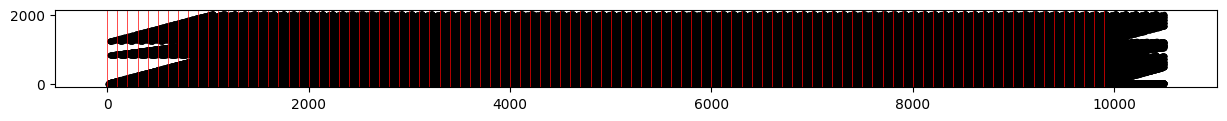

In [16]:
i,t = sm.it
plt.figure(figsize=(15,1))
plt.plot(t/msecond, i, '.k')
for onset in onsets:
    plt.axvline(onset/msecond, color='r', lw=.5)

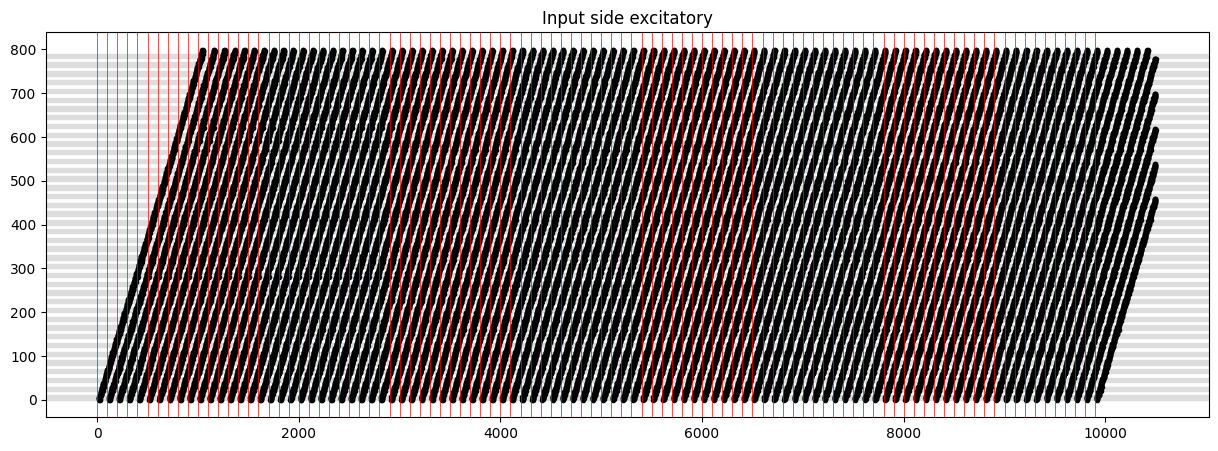

In [17]:
plt.figure(figsize=(15,5))
plt.title('Input side excitatory')
mask = np.isin(i, Ein.indices[:])
i_max = np.max(i[i <= Ein.indices[-1]]) - Ein.indices[0]
plt.plot(t[mask]/msecond, i[mask] - Ein.indices[0], '.k')
for onset in onsets:
    plt.axvline(onset/msecond, color='r', lw=.5)
for j in range(0, i_max, 2*N_Ein):
    plt.axhspan(j, j+N_Ein, color='#dddddd')

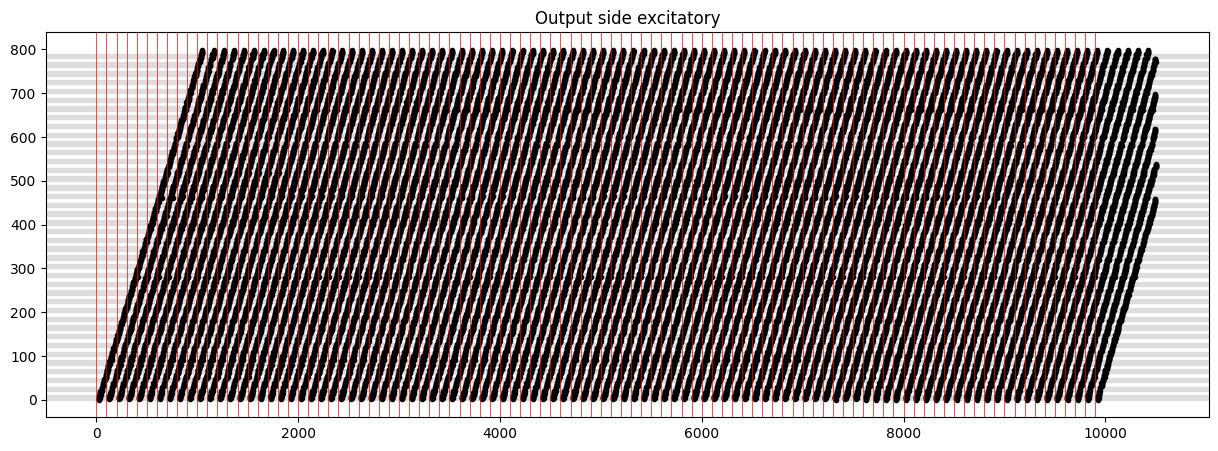

In [18]:
plt.figure(figsize=(15,5))
plt.title('Output side excitatory')
mask = np.isin(i, Eout.indices[:])
i_max = np.max(i[i <= Eout.indices[-1]]) - Eout.indices[0]
plt.plot(t[mask]/msecond, i[mask] - Eout.indices[0], '.k')
for onset in onsets:
    plt.axvline(onset/msecond, color='r', lw=.5)
for j in range(0, i_max, 2*N_Eout):
    plt.axhspan(j, j+N_Eout, color='#dddddd')

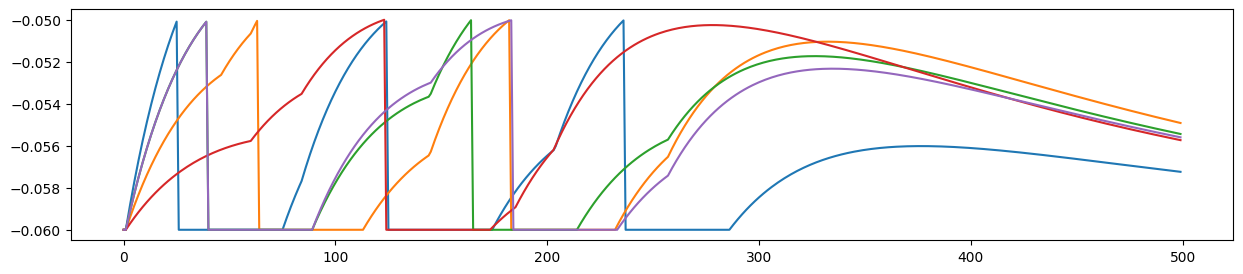

In [19]:
plt.figure(figsize=(15,3))
for v in vm.v[Sin.indices[:]]:
    plt.plot(v[:500])